# Predicting UFC fights using fighter statistics -- Making sense of incredible variation

On July 6th, 2019, the multi-orgiization champion and olympian, Ben Askren was set to fight Jorge Masvidal, a comparetivly unaccomplished joureyman fighter. The betting markets had predicted Askren's victory, setting the betting odds to -227/+130 in the favor of Askren. Some armchair analysts (myself included) were even more confidet in the champions chances.

<img src="askren_masvidal.png" width="1000" />

In just five seconds, Masvidal knocked the olympian unconcious with a rarely-used flying knee.

## Project Objective
It is undeniable that there is a large degree of variace and randomness in mixed martial arts fight data. But if given prior fight statistics, how much variance in this data can we explain through?

To Answer this question, we will clean and preprocess this data, and explore our ability to accuratly predict the winner using three different statistical models. We will employ cross-validated grid searching to find the optimal set of hyperparameters for each model. Finally, we will combine our three models into an ensemble-learning model to try to improve cross-validated accuracy.

# The Variance Problem

While randomness makes mixed martial arts an excitinng sport to watch, it makes it painful to analyze. Mixed Martial Arts is a real time sport that lacks empirical performance measurements, making sports-related analytics more difficult.

Here are just some examples of the MMA variance problem:

1) There is no way to measure force, speed, or landing location of a strike (compared to baseball pitches or hockey slapshots). Some headkicks might just glace off the top of a fighter's head, others (pictured above) are much more substantial. Both are recorded in the exact same way.

2) There are multiple ways for a fighter to "suddenly" win the match, allowing for plenty opportuities for a losing opponent to suddenly win the match.

3) Most recorded metrics are recorded and scored manually by UFC/Athletic Comission employees. Even referees intervene at varying times to stop the match (some fighters might stop the match right away when a fighter is unable to defend 2-3 head strikes in a row, other (more irresponsible) referees wait until 10+ undefended head strikes before interveening and declaring it a techincal knock out (when the fighter is concious but unable to defend themselves).

This creates a significant disconect beweet the fight data and what "actually" might have happened during the fight. Our goal is to try to see if this discoencted data has some predictive power.

# Part 0: Python Imports

In [137]:
## The essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA, KernelPCA

## Modeling
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Scoring and hyperparameter tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_classif, chi2, SelectPercentile, mutual_info_classif, VarianceThreshold
from sklearn.metrics import accuracy_score, confusion_matrix

# Part 1: Data Collection

Ultimatly, this was not an interesting step (don't worry, plenty of code ahead). All I had to do was download the csv file and read it into a pandas dataframe

In [5]:
dat_rough = pd.read_csv("ufcdata/data.csv")
dat_rough.shape

(5144, 145)

# Part 2: Data Preprocessing

## 2.1 -- Dropping non-analytic columns

Columns that fundamentally don't serve machine modeling purposes

In [6]:
not_needed_cols = ["title_bout","R_fighter","B_fighter","Referee","date","location","weight_class","no_of_rounds",\
                   "B_Stance","R_Stance","B_Weight_lbs","R_Weight_lbs"]

In [7]:
dat_rough.drop(columns = not_needed_cols, inplace=True)

## 2.2 -- Dealing with null data

In [8]:
dat_rough.isnull().sum(axis=1).value_counts().sort_index()

0      3355
1       193
2        61
3        31
4         8
49      795
50      170
51       65
52       35
53       12
98      243
99       93
100      31
101      30
102      19
103       2
104       1
dtype: int64

Theres a pretty sudden jump from rows having 50 null value rows to rows having around 100 nulls, lets start with dropping rows that have close to 100 null values.

In [9]:
dat_rough.dropna(thresh = 75, inplace = True)

A large portion of the missing data is from fight statistics, these are critical, so I'll have to drop them

In [10]:
dat_rough.isna().sum().sort_values()[80:100]

R_avg_CLINCH_att             231
R_avg_BODY_landed            231
R_avg_BODY_att               231
B_Reach_cms                  508
B_avg_opp_DISTANCE_att       846
B_avg_opp_DISTANCE_landed    846
B_avg_opp_GROUND_att         846
B_avg_opp_GROUND_landed      846
B_avg_opp_KD                 846
B_avg_opp_HEAD_landed        846
B_avg_opp_CLINCH_landed      846
B_avg_opp_LEG_att            846
B_avg_opp_HEAD_att           846
B_avg_DISTANCE_landed        846
B_avg_CLINCH_landed          846
B_avg_DISTANCE_att           846
B_avg_opp_LEG_landed         846
B_avg_CLINCH_att             846
B_avg_BODY_landed            846
B_avg_BODY_att               846
dtype: int64

In [11]:
dat_rough.dropna(thresh = 86, inplace = True)

It looks like the reach columns (the length of each fighters' arms) are fairly normally distributed with a large proportion near the center for mean, but a decently large non-normal spread for age and height, I will mean-impute the reach columns and drop rows with nulls in age/height

In [12]:
dat_rough.isna().sum().sort_values()[125:]

B_avg_opp_GROUND_landed        0
B_avg_opp_DISTANCE_landed      0
B_current_win_streak           0
B_Height_cms                   1
R_age                         12
B_age                         56
R_Reach_cms                  111
B_Reach_cms                  260
dtype: int64

Fairly normal distribution here, imputing the mean value seems fairly rational

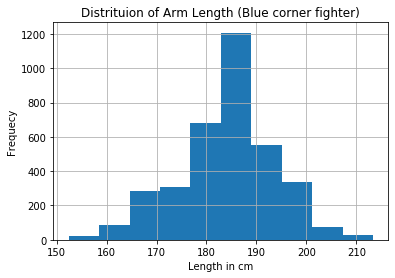

In [136]:
dat_rough.B_Reach_cms.hist()
plt.title("Distrituion of Arm Length (Blue corner fighter)")
plt.xlabel("Length in cm")
plt.ylabel("Frequecy")
plt.show()

It doesnt seem too right to mean impute a column with this type of distribution, I will drop rows with nulls instead

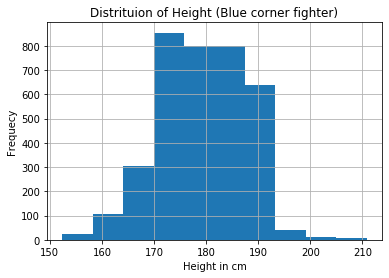

In [135]:
dat_rough.B_Height_cms.hist()
plt.title("Distrituion of Height (Blue corner fighter)")
plt.xlabel("Height in cm")
plt.ylabel("Frequecy")
plt.show()

In [14]:
## We impute the reach columns
dat_rough["B_Reach_cms"] = dat_rough["B_Reach_cms"].fillna(dat_rough["B_Reach_cms"].mean())
dat_rough["R_Reach_cms"] = dat_rough["R_Reach_cms"].fillna(dat_rough["R_Reach_cms"].mean())

## And drop the remaining null rows
dat_rough.dropna(axis=0, inplace=True)

In [15]:
dat_rough.shape

(3587, 133)

### Bonus Data Wrangle:

Since Draws only make up 1.56% of the data set (many of which are from earlier fights with different rule sets), I am going to drop them to turn this into a binary classification problem. This leaves all of my models vulnurable to out-of-sample outcomes, where I might encounter results that my model is not prepared to predict.

From my (perfectly fallable) experience with this sport, these draws are usually unexpexted and highly contested to begin with. Additionally, sports betting platforms do not even include draws as a predictive option. Including draws in the data (and thus, the scope of prediction) offers additional randomness at very little benefit.

In [16]:
dat_rough.Winner.value_counts()

Red     2319
Blue    1212
Draw      56
Name: Winner, dtype: int64

In [17]:
dat_clean = dat_rough[dat_rough["Winner"] != "Draw"]

Before we screen for significant columns, lets save a copy of the full dataset

In [18]:
dat_all_cols = dat_clean.copy()

## 2.3 -- Using Statistical tests to pre-screen unimpactful columns

Matches that end with a Blue corner victory tend to have a higher amount times when the blue fighter sucsessfully lands distance strikes. This makes the feature, B_avg_DISTANCE_landed, a good candidate for our feature set.

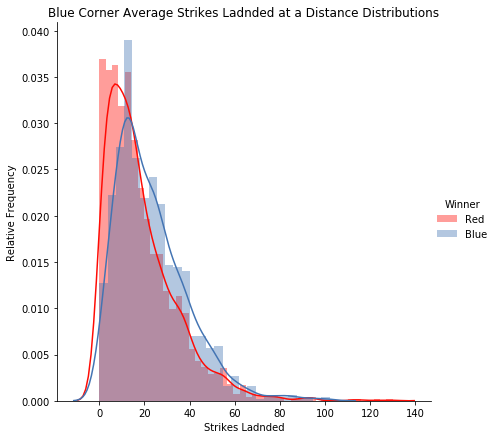

In [203]:
## Setting our color pallete
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

## Our plot
sns.FacetGrid(dat_clean,hue='Winner',size=6).map(sns.distplot,'B_avg_DISTANCE_landed').add_legend()
plt.title('Blue Corner Average Strikes Ladnded at a Distance Distributions')
plt.xlabel('Strikes Ladnded')
plt.ylabel('Relative Frequency')
plt.show()

When we look at the distributions for the blue corner fighter's significant strikes landing accuracy, there is no difference in distribution between matches whith a blue corner victory and matches with a red corner victory. Since there is no difference, We can remove this variable from our feature set.

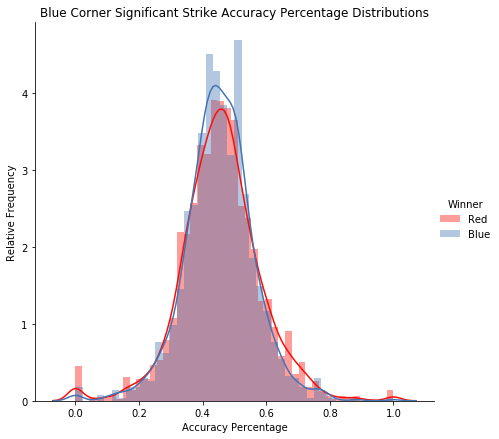

In [201]:
sns.FacetGrid(dat_clean,hue='Winner',size=6).map(sns.distplot,'B_avg_SIG_STR_pct').add_legend()
plt.title('Blue Corner Significant Strike Accuracy Percentage Distributions')
plt.xlabel('Accuracy Percentage')
plt.ylabel('Relative Frequency')
plt.show()

To fully automate this process, we loop through every possible feature set and conduct a two sample t-test. This will tell us if we have significant evidence that there is a difference in a given statistic between matches when the blue corner wins and when the red corner wins.

In [19]:
insignificant_cols = []

## We loop through every feature and seperate them into two groups, features where the blue fighter won and feature
## Where the red fighter won. We see if there is a statistically sigificant difference in feature at the 0.05 level
for col_index in range(1, len(dat_clean.columns)):
    col = dat_clean.columns[col_index]
    
    g1 = dat_clean[dat_clean["Winner"] == "Blue"][col]
    g2 = dat_clean[dat_clean["Winner"] == "Red"][col]
    
    pval = ttest_ind(g1, g2)[1]
    
    if pval > 0.05:
        insignificant_cols.append(col)
        
print(len(insignificant_cols), "Insignificant Features")

C:\Users\Alex\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Alex\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Alex\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


35 Insignificant Features


In [20]:
dat = dat_clean.drop(columns=insignificant_cols)

In [21]:
dat.shape

(3531, 98)

## 2.4 -- Label Transformation and Feature Seperation

In [22]:
label = LabelEncoder()
y = label.fit_transform(dat["Winner"])
features = dat.iloc[:,1:]

In [25]:
s_scale = StandardScaler()
r_scale = RobustScaler()
p_transform = PowerTransformer(method="yeo-johnson")
q_transform = QuantileTransformer()

## Issues With Correlation:

Our data has a lot of inherent feature correlation. Number of head-striked landed is heavily related to number of head-strikes attempted. Head-strike accuracy (percentage) is directly related to head-strikes attempted and landed.

For this reason, we should seperate our features into 4 different data sets:

1) strikes/manuvers attempted

2) strikes/maneuvers landed

3) strike/maneuver percentage

4) all other features (i.e. weight, height, previous wins)

Our feature sets will be one of the first 3 groups, comined with the 4th group

In [26]:
att_cols = []
pct_cols = []
landed_cols = []
other_cols = []


for col in features.columns:
    if col[-3:] == "att":
        att_cols.append(col)
        
    elif col[-3:] == "pct":
        pct_cols.append(col)
    
    elif col[-6:] == "landed":
        landed_cols.append(col)
        
    else:
        other_cols.append(col)

print(len(att_cols), "'att' features")
print(len(landed_cols), "'landed' features")
print(len(pct_cols), "'percent' features")
print(len(other_cols), "other features")

32 'att' features
30 'landed' features
6 'percent' features
29 other features


In [27]:
## Setting the seed (10/06/2018), the date of the infamous McGregor vs Nurmagomedov match
np.random.seed(100618)

x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, stratify = y)

In [28]:
x_train_att, x_test_att = x_train[att_cols + other_cols], x_test[att_cols + other_cols]
x_train_land, x_test_land = x_train[landed_cols + other_cols], x_test[landed_cols + other_cols]
x_train_pct, x_test_pct = x_train[pct_cols + other_cols], x_test[pct_cols + other_cols]

# Time to Model:

A quick look at various classifiers showed that Logistic Regression, SVM, and Random Forests tended to have the highest average accuracy when doing 10-fold cross validation

K Nearest Classifiers, Gradient Boosted Trees did not perform too well. Decision Tree's and Adaboosts were middle of the pack. For that reason, I will continue with a more in-depth analysis with Logistic Gregression, SVM, and Random Forests.

Given the smaller size of the dataset(~3,500 training examples), Bringing the validation folds down to 5 might make more sense (this will lead to a decrease in variacne/increase in bias, but it is still much better than a basic holdout validation)

# Lets look at Logistic Regression

After running an exhaustive grid search on possible hyperparameters. I've found that using a robust scaler, PCA (until 95% of the variance is covered) and no penalty/regularization makes for the most accurate model.

In [93]:
features = landed_cols + other_cols

full_logit_pipe = make_pipeline(
    r_scale,
    PCA(n_components=0.95),
    LogisticRegression(max_iter = 10000, 
                       penalty ='none')

)

full_logit_pipe.fit(x_train[features], y_train)

print("avg mean, cv=5:", np.mean(cross_val_score(full_logit_pipe , x_train[features], y_train, cv=5)))
print("avg mean, cv=10:", np.mean(cross_val_score(full_logit_pipe , x_train[features], y_train, cv=10)))

avg mean, cv=5: 0.6774097784472479
avg mean, cv=10: 0.6763501491115955


If you want to look at the hyperparmeters being examined, I've included the gridsearch-cv code

Heads up about running this, this takes about an hour to run and includes 3240 model fits

In [90]:
# from sklearn.feature_selection import VarianceThreshold

# logit_pipe = Pipeline([
#     ("scale",'passthrough'),
#     ("reduce_dim", "passthrough"),
#     ("clf" ,LogisticRegression(max_iter = 10000))])


# logit_pipe.get_params


# scalers = [s_scale, r_scale, p_transform, q_transform]

# params_logit = [                
#                 {"scale":scalers,
#                 "reduce_dim":[PCA()],
#                 "reduce_dim__n_components":[0.5, 0.75, 0.9, 0.95],
#                 "clf__penalty":["l1", "l2", 'none'],
#                 "clf__C":[0.01, 0.1, 0.5]},
               
#                {"scale":scalers,
#                 "reduce_dim":[KernelPCA()],
#                 "reduce_dim__kernel":['poly', 'rbf', 'sigmoid'],
#                 "clf__penalty":["l1", "l2", 'none'],
#                 "clf__C":[0.01, 0.1, 0.5]},
                
#                 {"scale":scalers,
#                 "reduce_dim":[SelectKBest(chi2), SelectKBest(mutual_info_classif)],
#                 "reduce_dim__k":[3, 5, 10, 20],
#                 "clf__penalty":["l1", "l2", 'none'],
#                 "clf__C":[0.01, 0.1, 0.5]},
                
#                 {"scale":scalers,
#                 "reduce_dim":[SelectPercentile()],
#                 "reduce_dim__percentile":[0.5, 0.75, 0.9],
#                 "clf__penalty":["l1", "l2", 'none'],
#                 "clf__C":[0.01, 0.1, 0.5]}]


# gs_logit= GridSearchCV(estimator = logit_pipe,
#                 param_grid = params_logit,
#                 scoring = "accuracy",
#                 cv = 5,
#                 refit = True,
#                 verbose = 2,
#                 n_jobs = -1)

# gs_logit.fit(x_train, y_train)

In [122]:
# logit_best_params = gs_logit.best_params_
# logit_best_score = gs_logit.best_score_
# logit_all_scores = gs_logit.cv_results_

# logit_best_score_hardcoded = {"C":0.01,
#                              "penalty":"none",
#                              "reduce_dim":PCA(n_components=0.95),
#                              "scale":r_scale}

# Lets look at SVMs

A grid-search for SVM suggests that the optimal pipeline hyperparameters include quantile transforming, PCA (up to 95%), and a Support Vector Model with a C coefficient of 1 and an rbg kernel.

In [81]:
features = landed_cols + other_cols

svm_pipe = make_pipeline(
    q_transform,
    PCA(n_components=0.95),
    SVC(C = 1, kernel = "rbf"))

svm_pipe.fit(x_train[features], y_train)

print("avg mean, cv=5:", np.mean(cross_val_score(svm_pipe , x_train[features], y_train, cv=5)))
print("avg mean, cv=10:", np.mean(cross_val_score(svm_pipe , x_train[features], y_train, cv=10)))

avg mean, cv=5: 0.671386430678466
avg mean, cv=10: 0.6745608099641631


Hyperparameter Tuning is below

Note: I am not checking for optimal gamma and C at the same time, both variables are responsible for higher classification at the cost of overfitting. Since combinations of models are more and more costly (especially with 5 fold cross validation), adding gamma to C (along with actual parameter options) would increase the total time and reasources needed to run this grid search by a factor of 3-4.

Heads up, this is 3600 model fittings and takes about 2-3 hours to run (on old hp laptop)

In [82]:
# svm_pipe = Pipeline([
#     ("scale",'passthrough'),
#     ("reduce_dim", "passthrough"),
#     ("clf" ,SVC())])


# svm_pipe.get_params


# scalers = [s_scale, r_scale, p_transform, q_transform]

# params_svm = [                
#                 {"scale":scalers,
#                 "reduce_dim":[PCA()],
#                 "reduce_dim__n_components":[0.5, 0.75, 0.9, 0.95],
#                 "clf__kernel":["linear","rbf", "poly",],
#                 "clf__C":[0.01,0.1, 1, 10]},
               
                
#                 {"scale":scalers,
#                 "reduce_dim":[SelectKBest(chi2), SelectKBest(mutual_info_classif)],
#                 "reduce_dim__k":[3, 5, 10, 20],
#                "clf__kernel":["linear","rbf", "poly",],
#                 "clf__C":[0.01,0.1, 1, 10]},
                
#                 {"scale":scalers,
#                 "reduce_dim":[SelectPercentile()],
#                 "reduce_dim__percentile":[0.5, 0.75, 0.9],
#                 "clf__kernel":["linear","rbf", "poly",],
#                 "clf__C":[0.01,0.1, 1, 10]}]



# gs_svm= GridSearchCV(estimator = svm_pipe,
#                 param_grid = params_svm,
#                 scoring = "accuracy",
#                 cv = 5,
#                 refit = True,
#                 verbose = 2,
#                 n_jobs = -1)

# gs_svm.fit(x_train, y_train)

In [120]:
# svm_best_params = gs_svm.best_params_
# svm_best_score = gs_svm.best_score_
# svm_all_scores = gs_svm.cv_results_

## Hard coding to be safe
# svm_best_params_hard_coded = {"c":1,
#                              "kernel":"rbf",
#                              "redice_dim":PCA(n_components=0.95),
#                              "scale":p_transform}

# Lets look at Random Forests

Since ensemble models like Random Forests thrive with larger data sets, 10 fold cross validation actually makes the models perfom worse than 5 fold. They also take much longer to run.

In [157]:
features = landed_cols + other_cols

rf = RandomForestClassifier(n_estimators = 2000,
                            bootstrap = True,
                            criterion = 'gini',
                            max_depth = None,
                            max_features = "log2",
                            min_samples_split = 20               
                           )

rf.fit(x_train[features], y_train)

print("avg mean, cv=5:", np.mean(cross_val_score(rf , x_train[features], y_train, cv=5)))
print("avg mean, cv=10:", np.mean(cross_val_score(rf , x_train[features], y_train, cv=5)))

avg mean, cv=5: 0.6720981610493943
avg mean, cv=10: 0.6724508880938931


#### Note on the num_estimators parameter:

Once your number of estimators is high enough, adding more offers little benefit and isnt worth the computing cost.

Hyperparameter Tuning. I will be keeping n_estimators steady at 2000, then doing one final test to see if increasing the number of estimators substantially increases cross validation accuracy. I tried a similar grid search that tried different n_estimators values and it ran for 2+ hours

The problem with ensemble models like random forest is that they take much longer than regular models to run. A 3000+ model grid search that normally takes 2 hours to run for logistic regression or SVM's will take 6+ hours to run with this model. Therefore, I need to do several batches of hyperparameter tuning.

There is no data scaling because random forest models do not need scaled data. We do not employ dimensionality reduction because ensemble models thrive with high-dimensional data.

#### Note:
Due to the random nature of this model, two models fitted with the same hyperparameters can differ in performance

In [129]:
# params = [{"min_samples_split":[2,5,10, 20],
#           "max_depth":[2,3,4,5],
#              "criterion":["gini","entropy"],
#           "min_samples_split":[2,5,10,20],
#           "max_features":[x_train.shape[1], "log2", "sqrt"]
#               }]

# params_1 = [{ "max_depth":[None,1,2,3],
#              "criterion":["gini","entropy"],
#           "bootstrap":[True, False]
#               }]

# params_2 = [{ "max_depth":[None,1,2,3],
#              "criterion":["gini"],
#              "bootstrap":[True],
#              "min_samples_split":[2,5,10]
#               }]

# params_3 = [{ "max_depth":[None],
#              "criterion":["gini"],
#              "bootstrap":[True],
#              "min_samples_split":[10,20,50,100],
#              "max_features" : ["sqrt", "log2"]
#               }]

# gs_rf = GridSearchCV(estimator = rf,
#                param_grid = params_3,
#                scoring = "accuracy",
#                cv = 5,
#                refit = True,
#                verbose = 2,
#                n_jobs = -1)
                       
# gs_rf.fit(x_train, y_train)

# gs_rf.best_params_
# gs_rf.score(x_test, y_test)

In [124]:
# rf_best_params = gs_rf.best_params_
# rf_best_score = gs_rf.best_score_
# rf_all_scores = gs_rf.cv_results_

# rf_best_params_hard_coded = {"bootstrap":True,
#                             "criterion":"gini",
#                             "max_depth":None,
#                             "max_features":"log2",
#                             "min_samples_split":20}

# Lets try to combine them into an ensemble classifier

In their textbook, Python Machine Learning, 3rd edition, the authors, Sebastian Reschka and Vahid Mirjalili provide many instances of incredibly useful code. This code block (seen below) creates a majority vote classifier, which can be initialized with a list of models. These models indibidually vote "via prediction" the outcome label of a certain observation. The outcome with the highest number of votes is selected.

This gives models the ability to cover each-others weaknesses. If one model has an unusual misclassification pattern, two different models can potentially cover some of those misclassifications, making their ensemble more powerful than each of the models individually. If all of the models misclassify in similar places, an ensemble model provides little assistance.

Just to reiterate: the code block directly below is the work of Sebastian Reschka and Vahid Mirjalili. For useful code like this and an overall amazing source of machine learing knowledge, please check out their textook: Python Machine Learning, 3rd edition.

In [109]:
## This entire code block comes from the authors, Sebastian Reschka and Vahid Mirjalili. 
## In addition to amazing code blocks like this, their machine learning textbook is packed with useful sample code.
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [110]:
mv_clf = MajorityVoteClassifier(classifiers=[logit_pipe, svm_pipe, rf])
mv_clf.fit(x_train[features],y_train)

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('scale', 'passthrough'),
                                                    ('reduce_dim',
                                                     'passthrough'),
                                                    ('clf',
                                                     LogisticRegression(max_iter=10000))]),
                                    Pipeline(steps=[('quantiletransformer',
                                                     QuantileTransformer()),
                                                    ('pca',
                                                     PCA(n_components=0.95)),
                                                    ('svc', SVC(C=1))]),
                                    RandomForestClassifier(max_features='log2',
                                                           min_samples_split=20,
                                                           n_estimators=2000)])

In [132]:
print("Test Data Accuracy:", mv_clf.score(x_test[features], y_test))

Test Data Accuracy: 0.685997171145686


In [112]:
print("avg mean, cv=5:", np.mean(cross_val_score(mv_clf , x_train[features], y_train, cv=5)))

avg mean, cv=5: 0.6784736082344819


We se that the ensemble learning classifier does not perform much better than any of the models that compose it. Ultimatly, this is likely due to patterns in the data can't be explaied through modeling (without irresponsibly overfitting).

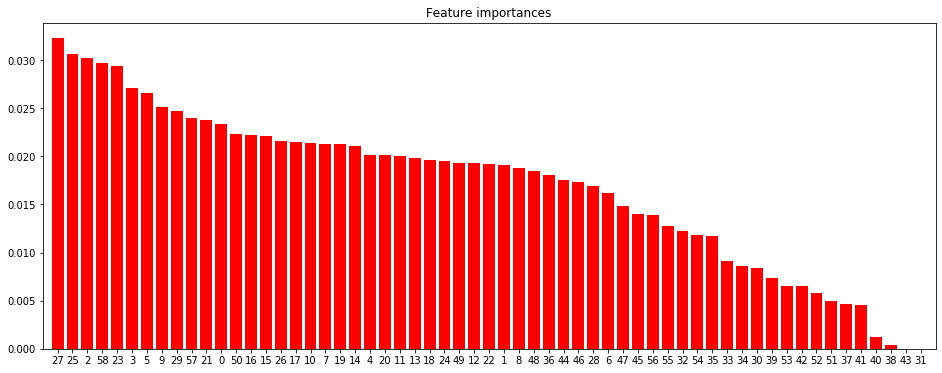

In [204]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(x_train[features].shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(x_train[features].shape[1]), indices)
plt.xlim([-1, x_train[features].shape[1]])
plt.show()

In [205]:
print("Top 10 most important indices:")
for i in indices[:10]:
    print(x_train[features].columns[i])

Top 10 most important indices:
R_avg_opp_SIG_STR_landed
R_avg_opp_HEAD_landed
B_avg_DISTANCE_landed
R_age
R_avg_opp_DISTANCE_landed
B_avg_HEAD_landed
B_avg_SIG_STR_landed
B_avg_opp_DISTANCE_landed
R_avg_opp_TOTAL_STR_landed
B_age


# Feature Importance Interpretation
We can use our random forest model from before to get a list of feature importace values, from our values, we see that:

1) There is no "Magical Feature". The features have a fairly similar level of importace. While the exact importance of the feature drops off, the first 15 features share a fairly similar level of importance

2) Defence Might be a little bit more important than offense. When we look

3) Younger might be better. We see that both age features are in the top 10 most important. The following plot suggests matches with a blue corner victory have fighters who tend to be a bit younger.

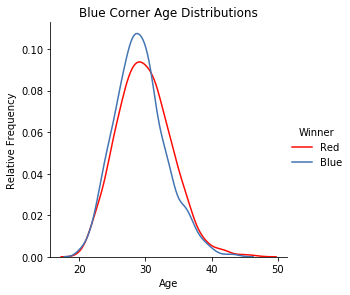

In [220]:
## Our plot
sns.FacetGrid(dat_clean,hue='Winner',size=4).map(sns.distplot,'B_age',hist=False).add_legend()
plt.title('Blue Corner Age Distributions')
plt.xlabel('Age')
plt.ylabel('Relative Frequency')
plt.show()

# Conclusion:





Overall, it looks like there is a fair amount of variance in ufc fight data that can't be accuratly captured by a model. It makes sense for there to be a good amount of unexplainable variance in combat sports, and past fight statistics might not be enough to fully cover that variance.

We saw that hypoerparameter tuning and model combination offered very little additional benefit to accuracy despite taking close to 80% of the time to implement and run (the optimized logistic regression model performed embarresingly similarly to a completely plain logistic regression). While every data project can be improved in one way or another, exhastive data preprocessing and hyperparameter tuning is well the "diminishing returns" portion of the project.

At ~67% accuracy, this model might still have some potential in generating a positive return via sports-betting. Ultimatly, attempts to predict the winner of a match demonstrates the high level of unexplainable variancne in mixed martial arts data.